# Office Data Exploration (Wednesday 28 May 2025)

In this notebook, we explore the sound features and properties of an average day at work.

We recorded a 5 hour segment. This was broken down into 30 second windows and then pro-processed using normalisation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

import os 

In [2]:
df = pd.read_csv("../features/extracted-features.csv")
df['segment_index'] = df['filename'].str.extract(r'(\d+)').astype(int)
df = df_sorted = df.sort_values('segment_index').reset_index(drop=True)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../features/extracted-features.csv'

# 1.0 Features

For each 30 second file, we extracted 8 features:

1. RMS: average power of the audio signal over time. Provides a quantitative measure of loudness. Useful for detecting quiet vs. loud segments and overall energy levels in the soundscape.
2. Spectral Centroid: “center of mass” of the frequency spectrum. Higher centroid = brighter or sharper sounds; lower centroid = duller or bass-heavy sounds. Useful for distinguishing tonal qualities and harshness.
3. Spectral Flatness: how noise-like or tonal a sound is. High flatness = broadband noise (e.g. chatter); low flatness = pure tone. Important for characterising sound texture.
4. Spectral Bandwidth: spread of frequencies around the centroid. Captures richness or narrowness of sound. Useful for identifying broadband natural ambiences vs. narrow tonal noises.
5. Zero-Crossing Rate (ZCR): how often the waveform crosses zero amplitude. High ZCR = noisy, transient-heavy sounds. Useful for detecting disruptions and percussive noise.
6. Amplitude Envelope: shape of the signal’s amplitude over time, capturing changes. Useful for identifying attack, sustain, and decay patterns in sounds.
7. Onset Density: Number of onset peaks (sudden energy changes) per time window. High onset density indicates a busy or active soundscape. Important for identifying calm vs. active segments.
8. Inter-Onset Interval (IOI): Average time gap between successive onsets. Indicates rhythmic regularity. Useful for detecting natural, wave-like rhythms vs. irregular office noise.

In summary, feature Descriptions and Purposes:
1. RMS: average loudness - for loud/quiet differentiation
2. Centroid: brightness - for tonal balancing
3. Flatness: noise-like vs tonal - for texture
4. Bandwidth: richness/spread - for spectral shaping
5. ZCR: noisiness/transients - for identifying disruptions
6. Envelope: dynamic shape - for smoothing dynamics
7. Onset Density: busy-ness - for calm vs active parts
8. IOI: rhythmic regularity - for natural sound flow
   
Could add the following features later:

1. Low-Frequency Energy Ratio: HVAC, distant traffic often dominate low frequencies;
2. Spectral Roll-off: captures how “bright” or “dull” a sound is overall, helps mimic nature’s spectral slopes
3. Spectral Contrast: useful for texture/richness analysis, e.g. noisy chatter vs. clean HVAC hum
4. Autocorrelation Peaks: Useful for periodic or repetitive mechanical sounds (e.g. typing)

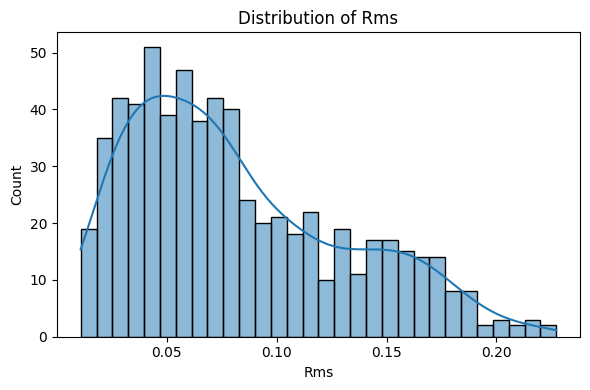

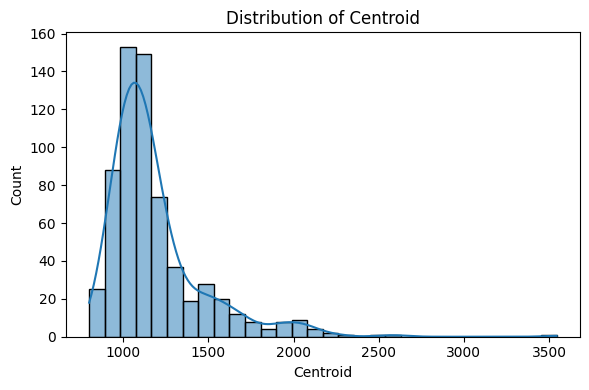

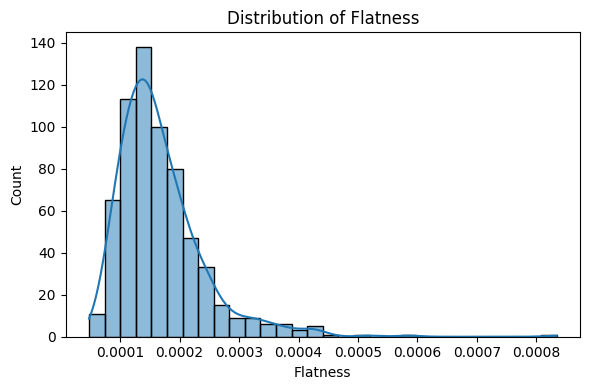

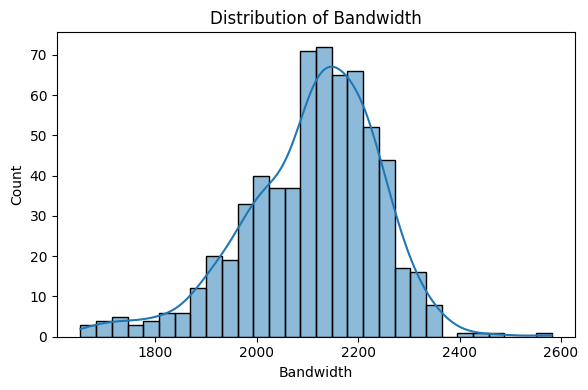

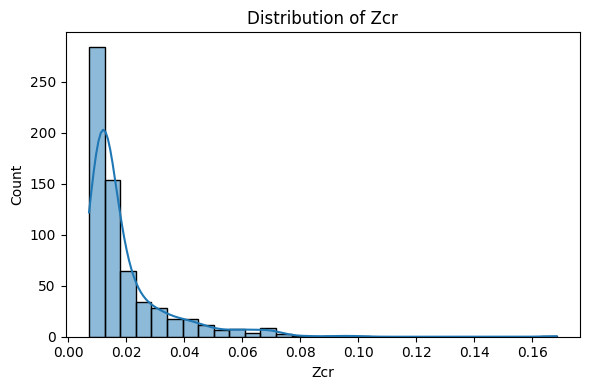

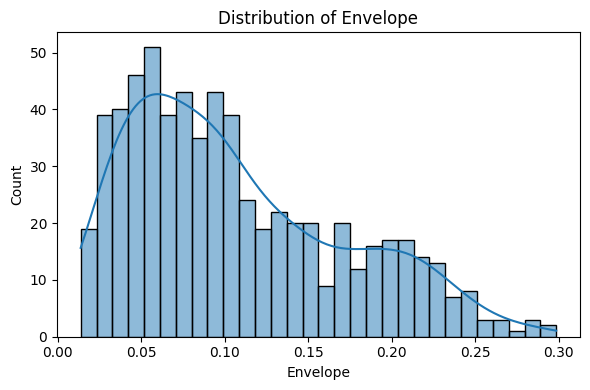

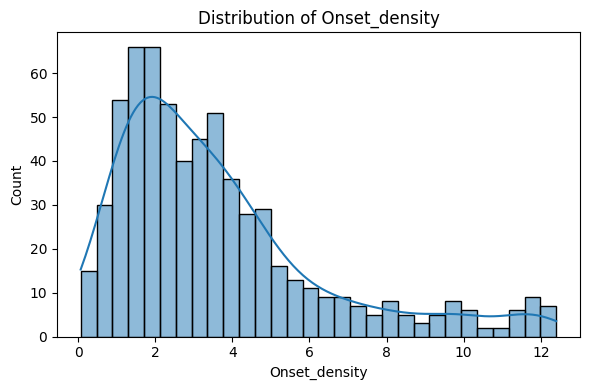

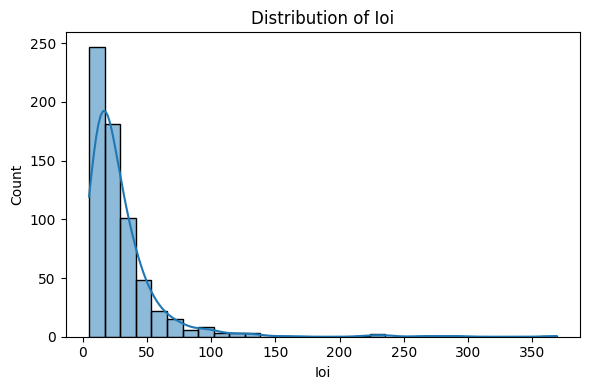

In [3]:
features_to_plot = ['rms', 'centroid', 'flatness', 'bandwidth', 'zcr', 'envelope', 'onset_density', 'ioi']

for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f"Distribution of {feature.capitalize()}")
    plt.xlabel(feature.capitalize())
    plt.ylabel("Count")
    plt.tight_layout()
    output_path = f"../data/plots/{feature}-distribution.png"
    plt.savefig(output_path)

## Observations:

RMS Distribution: Right-skewed (most segments are low RMS, some louder). Office recordings have a majority of quiet segments (background HVAC, distant chatter). Occasional loud events pull the tail rightward — door slams, close conversations. Relevance: Explore compressing or expanding this range to match natural dynamic range (forest sounds, for example, might have a more continuous RMS variation.

Spectral Centroid Distribution: Right-skewed (most segments have low centroid).
Most office sounds are dull or mid-range in brightness (HVAC, low chatter). Occasional sharp, bright sounds (typing, door slam) create the long tail. Relevance: In nature, centroid tends to be softer/warmer. Potential transformation could be to smooth out harsh brightness peaks to mimic gentle natural tones.

Spectral Flatness Distribution: Strongly skewed — most segments are low flatness. Majority of office segments are more tonal, steady sounds. Fewer segments are noisy (chatter, typing). Relevance: Nature has a mix of tonal and broadband textures — you can use flatness to modulate textural balance.

Spectral Bandwidth Distribution: Bell-shaped (more symmetric). Bandwidth is fairly stable around 2000–2200 Hz for most segments. Bandwidth does not vary as much as RMS or centroid. Relevance: Could be used as a targeted transformation dimension — e.g., to enrich spectral complexity in nature-inspired augmentation.

Envelope Distribution: Left-skewed — most segments have low average envelope, fewer with high dynamic fluctuations. Many segments have calm, stable envelopes. Some have sudden dynamic bursts. Relevance: Nature’s envelope shapes often breathe gently — transformation logic might emphasize smoother amplitude modulation.

ZCR Distribution: Strong right-skew. Most office segments are low in transient activity. Occasional high ZCR = sudden, noisy events (e.g., typing). Relevance:Nature’s environments generally have low ZCR (noisy water is an exception). Good dimension to smooth out harsh office noise transients.

Onset Density Distribution: Right-skewed — most segments have low onset density. Office is usually quiet with few sudden events. Some busy intervals (people moving around, typing bursts). Relevance: Nature can have rich but balanced onset density (rustling leaves, bird calls). Could guide how you modulate office sound “busy-ness.”

Inter-Onset Interval (IOI) Distribution: Right-skewed — mostly large IOI (quiet gaps), some smaller (bursty events). Most of the office environment is calm — few repeated rhythmic events. Nature’s rhythms tend to have smooth, wave-like periodicity — this can inform transformation logic to smooth out disruptive mechanical repetition.

# Correlations

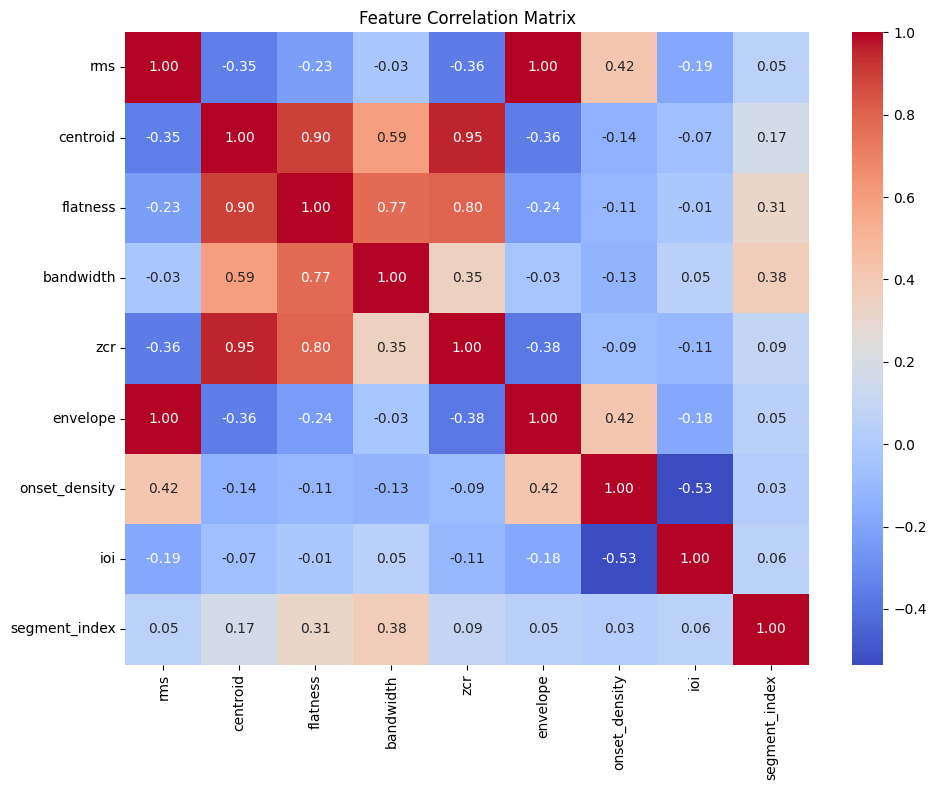

In [5]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
output_path = f"../data/plots/feature-correlations.png"
plt.savefig(output_path)

# Pairplots
To identify linear vs non linear functions for transformation (and additional verification of positive or negative relaton and correlation)

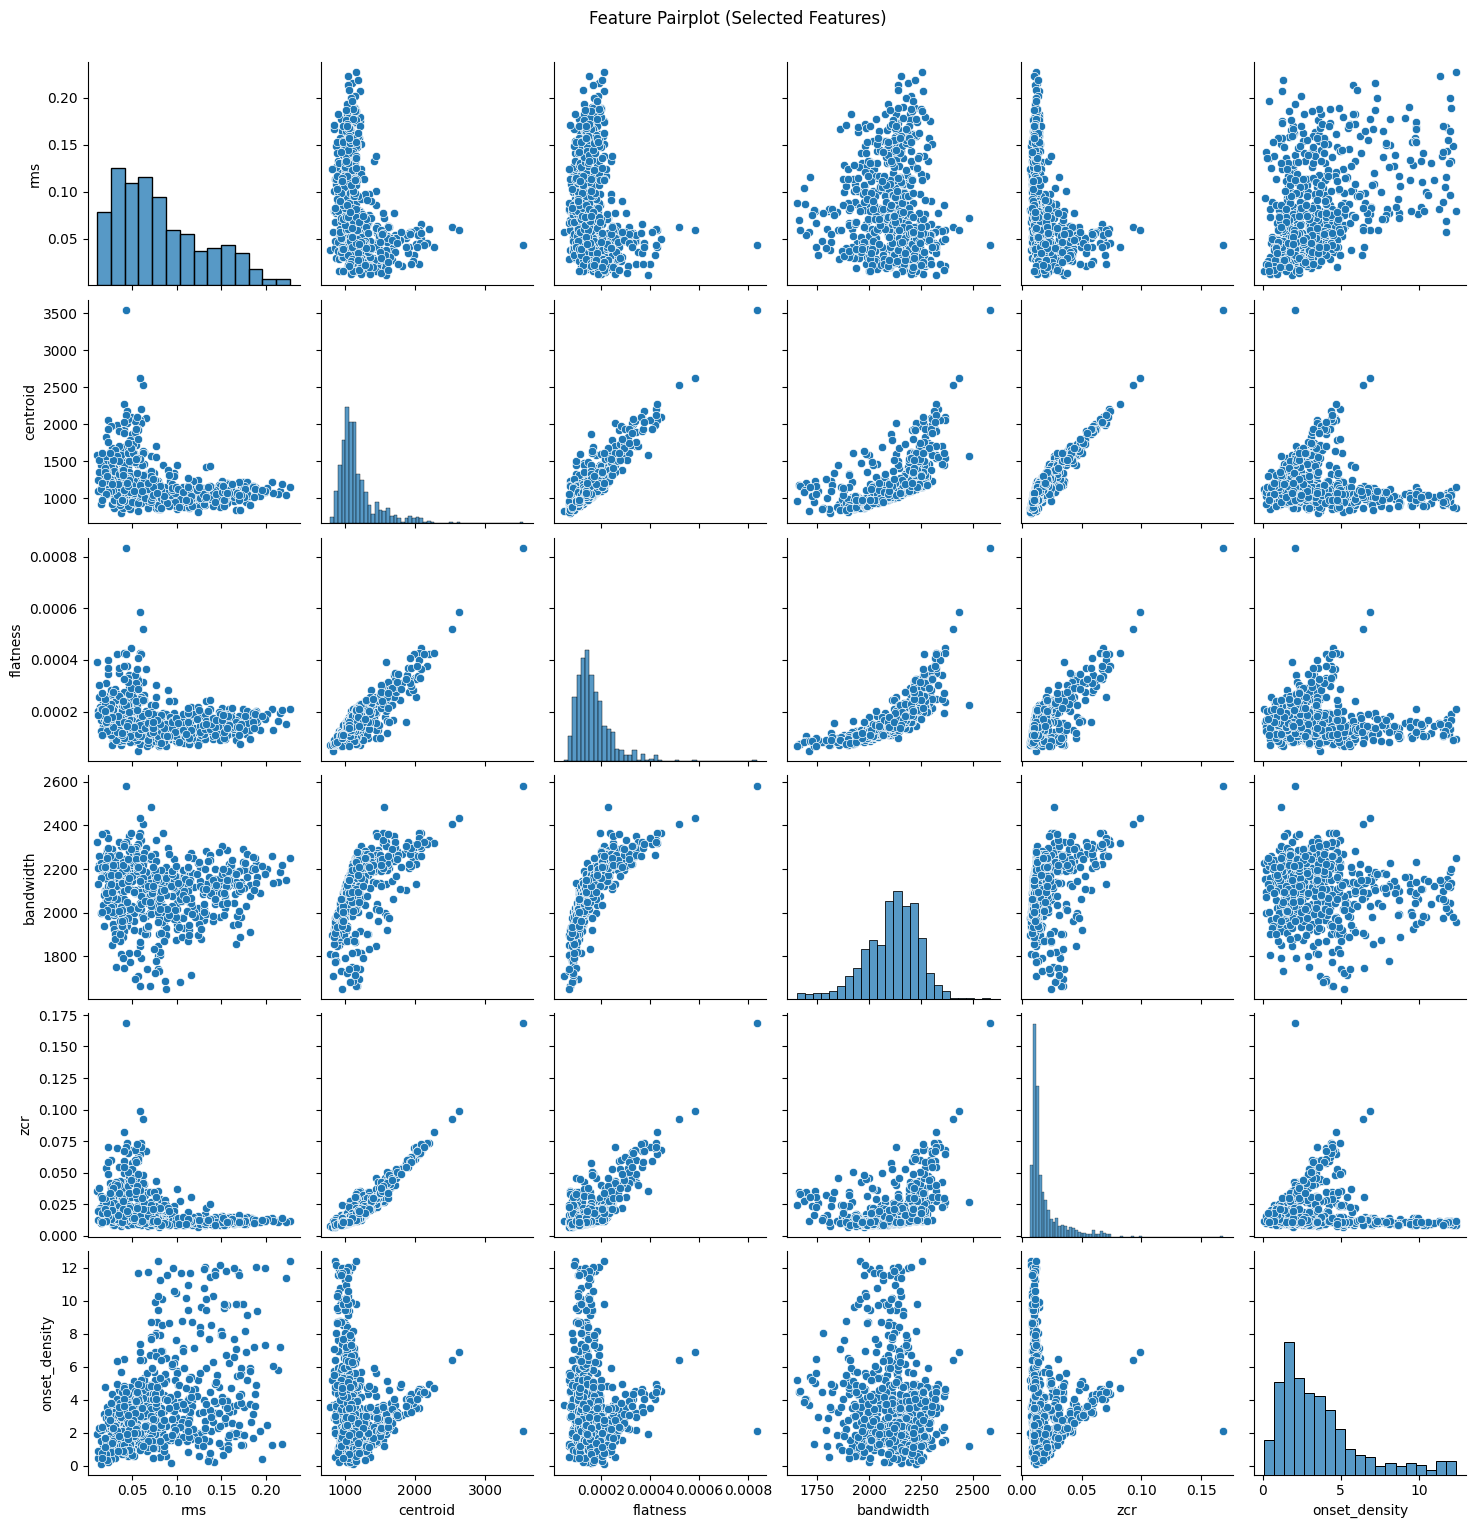

In [6]:
selected_features = ['rms', 'centroid', 'flatness', 'bandwidth', 'zcr', 'onset_density']
sns.pairplot(df[selected_features])
plt.suptitle("Feature Pairplot (Selected Features)", y=1.02)
output_path = f"../data/plots/feature-pairplots.png"
plt.savefig(output_path)

Q1. Variability — Do features vary enough to distinguish sounds?

Q2. Potential thresholds — E.g. low vs. high centroid or flatness to separate tonal vs. noisy sounds

Q3. Feature redundancy

Q4. Insights for design — How might these features reflect real office sounds vs. biophil

# BoxPlots for Each Feature

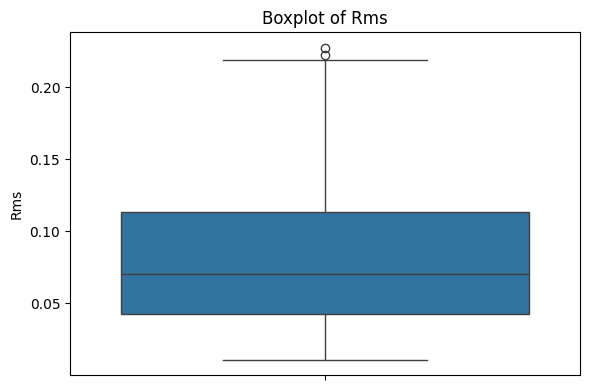

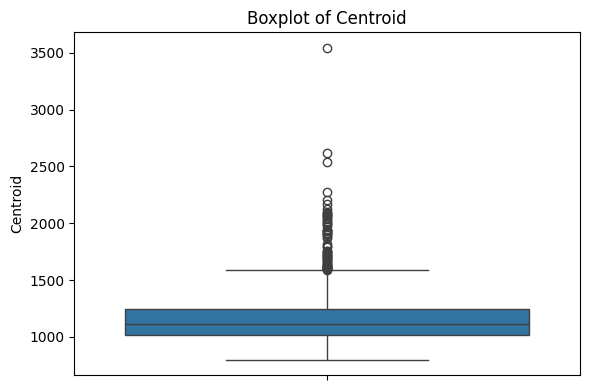

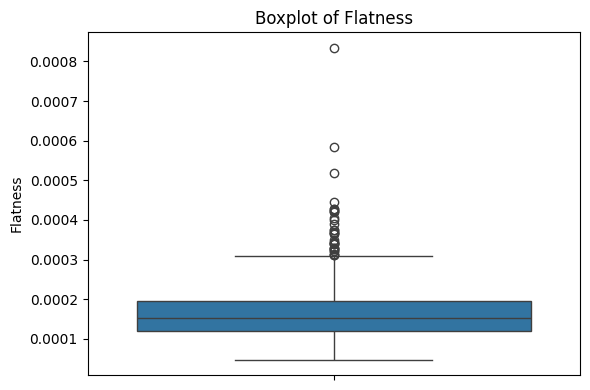

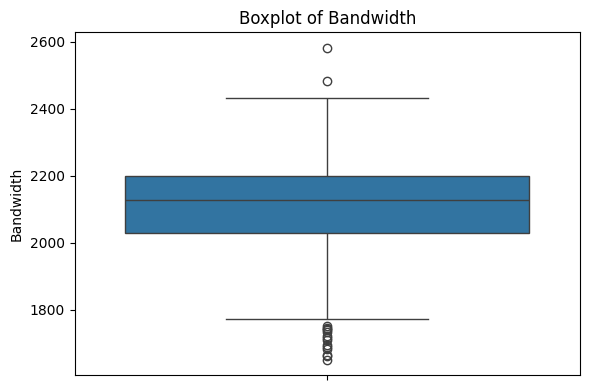

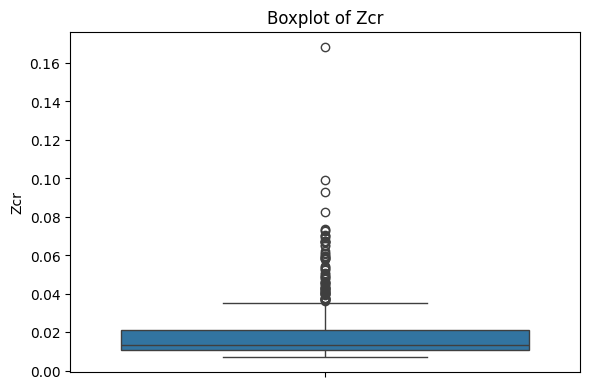

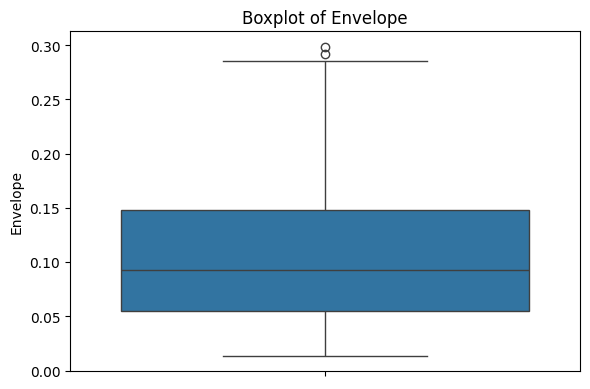

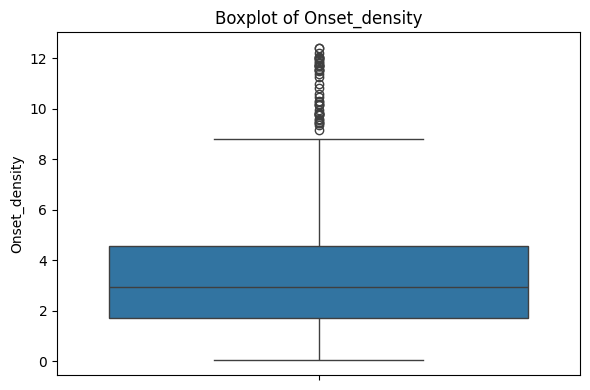

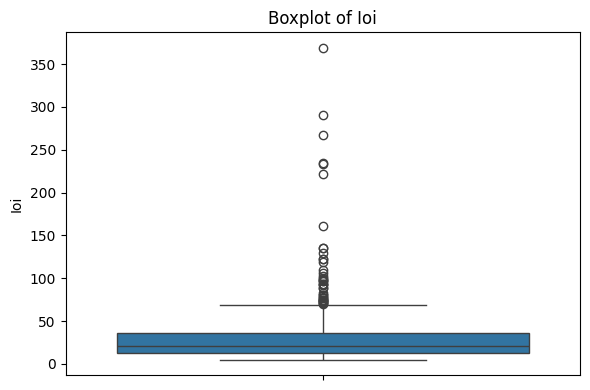

In [7]:
features_to_plot = ['rms', 'centroid', 'flatness', 'bandwidth', 'zcr', 'envelope', 'onset_density', 'ioi']

for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature.capitalize()}")
    plt.ylabel(feature.capitalize())
    plt.tight_layout()
    plt.show()

# Feature Selection Outcome:

Keep for transformations:
1. RMS: Loudness
2. Centroid: Brightness
3. Bandwidth: Richness
4. Flatness: Texture
5. ZCR: Transients/noisiness
6. Onset_density

Dropped: 
1. Envelope — since using RMS.
2. IOI - since using onset density

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df['centroid'], y=df['flatness'])
plt.title("Spectral Centroid vs. Spectral Flatness")
plt.xlabel("Centroid")
plt.ylabel("Flatness")
plt.tight_layout()
plt.show()


# 1.3 PCA

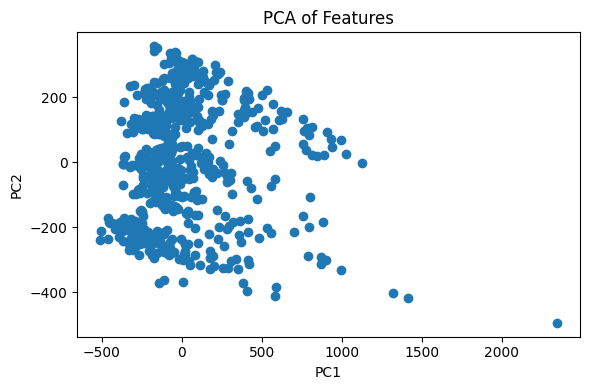

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_df)

plt.figure(figsize=(6, 4))
plt.scatter(pca_result[:,0], pca_result[:,1])
plt.title("PCA of Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
output_path = f"../data/plots/pca-features.png"
plt.savefig(output_path)

# 2.0 Sound Segments Compared to Data 

[todo] normalisation has resulted in a lot of noise.

We identified some interesting segments: `segment_004` is keyboard typing, `segment_006` is a conversation in the office, `segment_007` is outside office sounds, and `segment_206` is a quiet office.

In [11]:
# Sort by RMS in descending order
sorted_rms = df.sort_values('rms', ascending=False)

# Get the second loudest segment (index 1)
loudest_segment = sorted_rms.iloc[2]

# Find interesting segments
loudest_segment = loudest_segment
softest_segment = df.loc[df['rms'].idxmin()]
brightest_segment = df.loc[df['centroid'].idxmax()]
noisiest_segment = df.loc[df['flatness'].idxmax()]

# Assign labels for each
interesting_segments = [
    ("Loudest", loudest_segment),
    ("Softest", softest_segment),
    ("Brightest", brightest_segment),
    ("Noisiest", noisiest_segment)
]

# Create the HTML table
table_html = """
<table border='1'>
<tr>
    <th>Label</th>
    <th>Segment</th>
    <th>RMS</th>
    <th>Centroid</th>
    <th>Flatness</th>
    <th>Bandwidth</th>
    <th>Onset Density</th>
    <th>Play</th>
    <th>Note</th>
</tr>
"""

for label, row in interesting_segments:
    audio_path = f"../data/processed/{row['filename']}"
    audio_html = f"<audio controls src='{audio_path}'></audio>"
    
    # Optional short note for context
    if label == "Loudest":
        note = "High energy segment"
    elif label == "Softest":
        note = "Quietest environment"
    elif label == "Brightest":
        note = "Most treble-rich / harsh"
    elif label == "Noisiest":
        note = "Highest texture/noise"
    
    table_html += f"""
    <tr>
        <td>{label}</td>
        <td>{row['filename']}</td>
        <td>{row['rms']:.4f}</td>
        <td>{row['centroid']:.1f}</td>
        <td>{row['flatness']:.4f}</td>
        <td>{row['bandwidth']:.1f}</td>
        <td>{row['onset_density']:.1f}</td>
        <td>{audio_html}</td>
        <td>{note}</td>
    </tr>
    """

table_html += "</table>"

from IPython.display import HTML
HTML(table_html)


Label,Segment,RMS,Centroid,Flatness,Bandwidth,Onset Density,Play,Note
Loudest,segment_472.wav,0.2186,1187.7,0.0002,2220.2,1.3,,High energy segment
Softest,segment_206.wav,0.0109,1584.9,0.0004,2323.9,1.9,,Quietest environment
Brightest,segment_356.wav,0.0433,3544.2,0.0008,2581.5,2.1,,Most treble-rich / harsh
Noisiest,segment_356.wav,0.0433,3544.2,0.0008,2581.5,2.1,,Highest texture/noise


## Pre-processing Check: Normalisation

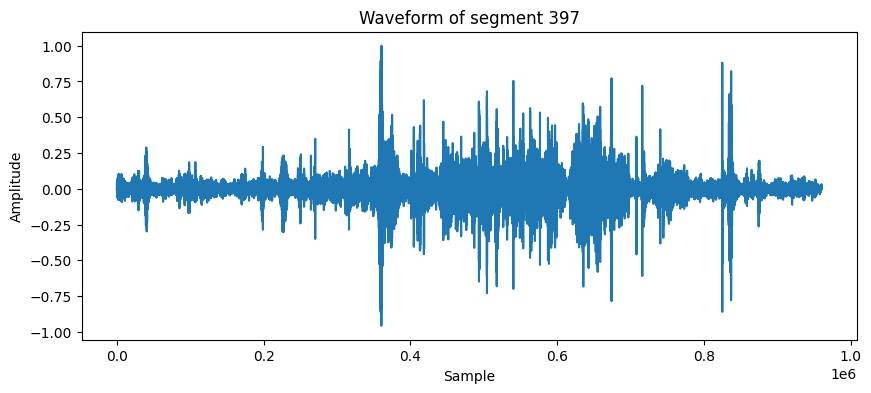

RMS: 0.04333511
Max amplitude: 0.9999695


In [20]:
segment_path = "../data/processed/segment_356.wav"
y, sr = librosa.load(segment_path, sr=None)

plt.figure(figsize=(10, 4))
plt.plot(y)
plt.title("Waveform of segment 397")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()
print("RMS:", librosa.feature.rms(y=y).mean())
print("Max amplitude:", y.max())

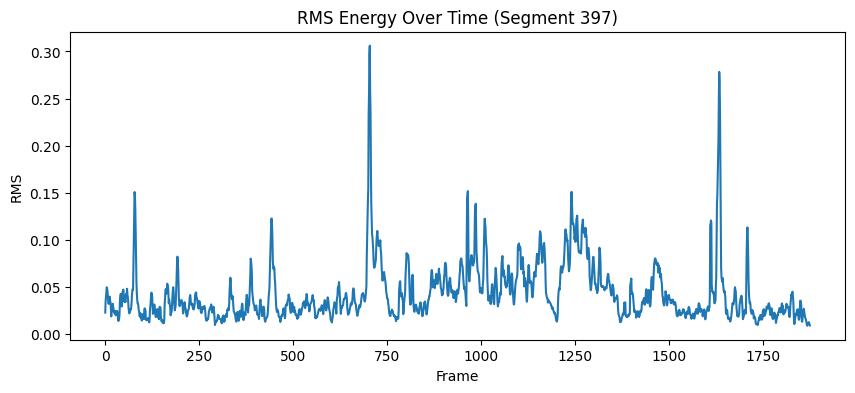

In [21]:
frame_length = 2048
hop_length = 512
rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]

plt.figure(figsize=(10, 4))
plt.plot(rms)
plt.title("RMS Energy Over Time (Segment 397)")
plt.xlabel("Frame")
plt.ylabel("RMS")
plt.show()

# Exploring Specific Office Sounds
segment-004: keyboard sounds

segment-006: conversation

segment-007: outside office noise

segment-206: quietish

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# Your list of key segments
selected_segments = ['segment_004.wav', 'segment_006.wav', 'segment_007.wav', 'segment_206.wav']

for seg_name in selected_segments:
    audio_path = f"../data/processed/{seg_name}"
    
    # Load audio
    y, sr = librosa.load(audio_path, sr=None)
    
    # Display audio player
    audio_html = f"<audio controls src='{audio_path}'></audio>"
    display(HTML(audio_html))
    
    # Display feature values
    segment_features = df[df['filename'] == seg_name]
    print(f"Feature values for {seg_name}:")
    display(segment_features[['rms', 'centroid', 'flatness', 'bandwidth', 'zcr', 'onset_density']])
    
    # Plot waveform
    plt.figure(figsize=(10, 2))
    plt.plot(y, color='blue')
    plt.title(f"Waveform: {seg_name}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    
    # Plot spectrogram
    plt.figure(figsize=(10, 4))
    S = librosa.stft(y)
    S_db = librosa.amplitude_to_db(abs(S))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram: {seg_name}")
    plt.tight_layout()

In [ ]:
import seaborn as sns

# Get a DataFrame with just your selected segments
subset_df = df[df['filename'].isin(selected_segments)]

# Plot a bar chart for RMS
plt.figure(figsize=(8, 4))
sns.barplot(x='filename', y='rms', data=subset_df, palette='viridis')
plt.title("RMS Levels Across Selected Office Segments")
plt.xlabel("Segment")
plt.ylabel("RMS")
plt.tight_layout()

# Comparing Nature vs Office Sound Profiles

### Continuous Feature-Based Transformation
This approach directly manipulates frame-by-frame acoustic features (e.g., RMS, centroid, flatness) using continuous mathematical functions. Unlike event-based segmentation, transformations are applied continuously to the evolving feature values in time, enabling real-time adaptability. The goal is to reshape office sound features towards target "biophilic profiles," defined by analyzing natural sound recordings.

Potential transformation functions include dynamic range compression for RMS, spectral tilt filters for centroid, and noise layer modulation for flatness. These functions are calibrated to mimic the statistical or dynamic patterns observed in natural environments.

In [ ]:
def nature_inspired_rms_compression(rms, target_rms_profile):
    # Example: scale office RMS towards target natural RMS profile
    scaling_factor = target_rms_profile / (rms + 1e-6)
    return rms * scaling_factor

def centroid_lowpass_filter(centroid, cutoff=3000):
    # Lower spectral centroid to mimic warmer natural sounds
    if centroid > cutoff:
        centroid = cutoff + (centroid - cutoff) * 0.5
    return centroid


“In this approach, I’ll develop transformation functions that directly operate on continuous acoustic features of office recordings, smoothing or reshaping them to better align with the nuanced dynamic patterns found in nature. These transformations are not simply plug-and-play DSP filters; they’re designed to replicate the specific rhythmic, spectral, and dynamic signatures of natural environments, extracted from reference datasets.”



AI/ML Possibility

Regression models (e.g., Random Forest Regression) to learn the mapping from office feature trajectories to target natural feature trajectories.

Recurrent Neural Networks (RNNs) to learn temporal modulation of features (like natural RMS “breathing”).

### State Space Navigation
This approach conceptualizes each 30-second segment as a vector in a high-dimensional feature space (RMS, centroid, bandwidth, etc.). Nature and office sounds form distinct clusters in this space. Transformation is framed as moving office sound feature vectors towards the nature-sound cluster region. This approach highlights global alignment of feature sets and can leverage visualization tools like PCA to validate transformation performance.


In [ ]:
def vector_shift_towards_nature(office_vector, nature_centroid, alpha=0.2):
    # Smoothly move office feature vector towards nature centroid
    return office_vector + alpha * (nature_centroid - office_vector)
